
<a id='estspec'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Estimation of Spectra


<a id='index-1'></a>

## Contents

- [Estimation of Spectra](#Estimation-of-Spectra)  
  - [Overview](#Overview)  
  - [Periodograms](#Periodograms)  
  - [Smoothing](#Smoothing)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries

In [1]:
!pip install quantecon

## Overview

In a [previous lecture](https://lectures.quantecon.org/py/arma.html#arma) we covered some fundamental properties of covariance stationary linear stochastic processes

One objective for that lecture was to introduce spectral densities — a standard and very useful technique for analyzing such processes

In this lecture we turn to the problem of estimating spectral densities and other related quantities from data


<a id='index-2'></a>
Estimates of the spectral density are computed using what is known as a periodogram — which in
turn is computed via the famous [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)

Once the basic technique has been explained, we will apply it to the analysis of several key macroeconomic time series

For supplementary reading, see [[Sar87]](https://lectures.quantecon.org/py/zreferences.html#sargent1987) or [[CC08]](https://lectures.quantecon.org/py/zreferences.html#cryerchan2008)


<a id='periodograms'></a>

## Periodograms

[Recall that](https://lectures.quantecon.org/py/arma.html#arma-specd) the spectral density $ f $ of a covariance stationary process with
autocorrelation function $ \gamma $ can be written

$$
f(\omega) = \gamma(0) + 2 \sum_{k \geq 1} \gamma(k) \cos(\omega k),
\qquad \omega \in \mathbb R
$$

Now consider the problem of estimating the spectral density of a given time series, when $ \gamma $ is unknown

In particular, let $ X_0, \ldots, X_{n-1} $ be $ n $ consecutive observations of a single time series that is assumed to be covariance stationary

The most common estimator of the spectral density of this process is the *periodogram* of $ X_0, \ldots, X_{n-1} $, which is defined as


<a id='equation-estspec-p'></a>
$$
I(\omega)
:= \frac{1}{n} \left| \sum_{t=0}^{n-1} X_t e^{i t \omega} \right|^2,
\qquad \omega \in \mathbb R \tag{1}
$$

(Recall that $ |z| $ denotes the modulus of complex number $ z $)

Alternatively, $ I(\omega) $ can be expressed as

$$
I(\omega)
= \frac{1}{n}
\left\{
\left[\sum_{t=0}^{n-1} X_t \cos(\omega t) \right]^2 +
\left[\sum_{t=0}^{n-1} X_t \sin(\omega t) \right]^2
\right\}
$$

It is straightforward to show that the function $ I $ is even and $ 2
\pi $-periodic (i.e., $ I(\omega) = I(-\omega) $ and $ I(\omega +
2\pi) = I(\omega) $ for all $ \omega \in \mathbb R $)

From these two results, you will be able to verify that the values of
$ I $ on $ [0, \pi] $ determine the values of $ I $ on all of
$ \mathbb R $

The next section helps to explain the connection between the periodogram and the spectral density

### Interpretation


<a id='index-4'></a>
To interpret the periodogram, it is convenient to focus on its values at the *Fourier frequencies*

$$
\omega_j := \frac{2 \pi j}{n},
\quad j = 0, \ldots, n - 1
$$

In what sense is $ I(\omega_j) $ an estimate of $ f(\omega_j) $?

The answer is straightforward, although it does involve some algebra

With a bit of effort one can show that, for any integer $ j > 0 $,

$$
\sum_{t=0}^{n-1} e^{i t \omega_j }
= \sum_{t=0}^{n-1} \exp \left\{ i 2 \pi j \frac{t}{n} \right\} = 0
$$

Letting $ \bar X $ denote the sample mean $ n^{-1} \sum_{t=0}^{n-1} X_t $, we then have

$$
n I(\omega_j)
 = \left| \sum_{t=0}^{n-1} (X_t - \bar X) e^{i t \omega_j } \right|^2
 =  \sum_{t=0}^{n-1} (X_t - \bar X) e^{i t \omega_j }
\sum_{r=0}^{n-1} (X_r - \bar X) e^{-i r \omega_j }
$$

By carefully working through the sums, one can transform this to

$$
n I(\omega_j) = \sum_{t=0}^{n-1} (X_t - \bar X)^2 +
2 \sum_{k=1}^{n-1} \sum_{t=k}^{n-1} (X_t - \bar X)(X_{t-k} - \bar X)
\cos(\omega_j k)
$$

Now let

$$
\hat \gamma(k)
:= \frac{1}{n} \sum_{t=k}^{n-1} (X_t - \bar X)(X_{t-k} - \bar X),
\qquad k = 0,1,\ldots, n-1
$$

This is the sample autocovariance function, the natural “plug-in estimator” of the [autocovariance function](https://lectures.quantecon.org/py/arma.html#arma-defs) $ \gamma $

(“Plug-in estimator” is an informal term for an estimator found by replacing expectations with sample means)

With this notation, we can now write

$$
I(\omega_j) = \hat \gamma(0) +
2 \sum_{k=1}^{n-1} \hat \gamma(k) \cos(\omega_j k)
$$

Recalling our expression for $ f $ given [above](#periodograms),
we see that $ I(\omega_j) $ is just a sample analog of $ f(\omega_j) $

### Calculation


<a id='index-5'></a>
Let’s now consider how to compute the periodogram as defined in [(1)](#equation-estspec-p)

There are already functions available that will do this for us
— an example is `statsmodels.tsa.stattools.periodogram` in the `statsmodels` package

However, it is very simple to replicate their results, and this will give us a platform to make useful extensions

The most common way to calculate the periodogram is via the discrete Fourier transform,
which in turn is implemented through the [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm

In general, given a sequence $ a_0, \ldots, a_{n-1} $, the discrete
Fourier transform computes the sequence

$$
A_j := \sum_{t=0}^{n-1} a_t \exp \left\{ i 2 \pi \frac{tj}{n} \right\},
\qquad j = 0, \ldots, n-1
$$

With `numpy.fft.fft` imported as `fft` and $ a_0, \ldots, a_{n-1} $ stored in NumPy array `a`, the function call `fft(a)` returns the values $ A_0, \ldots, A_{n-1} $ as a NumPy array

It follows that, when the data $ X_0, \ldots, X_{n-1} $ are stored in array `X`, the values $ I(\omega_j) $ at the Fourier frequencies, which are given by

$$
\frac{1}{n} \left| \sum_{t=0}^{n-1} X_t \exp \left\{ i 2 \pi \frac{t j}{n} \right\} \right|^2,
\qquad j = 0, \ldots, n-1
$$

can be computed by `np.abs(fft(X))**2 / len(X)`

Note: The NumPy function `abs` acts elementwise, and correctly handles complex numbers (by computing their modulus, which is exactly what we need)

A function called `periodogram` that puts all this together can be found [here](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/estspec.py)

Let’s generate some data for this function using the `ARMA` class from [QuantEcon.py](https://github.com/QuantEcon/QuantEcon.py) (see the [lecture on linear processes](https://lectures.quantecon.org/py/arma.html#arma) for more details)

Here’s a code snippet that, once the preceding code has been run, generates data from the process


<a id='equation-esp-arma'></a>
$$
X_t = 0.5 X_{t-1} + \epsilon_t - 0.8 \epsilon_{t-2} \tag{2}
$$

where $ \{ \epsilon_t \} $ is white noise with unit variance, and compares the periodogram to the actual spectral density

/home/quantecon/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


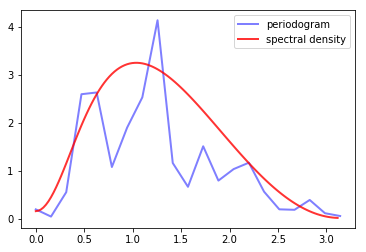

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import ARMA, periodogram

n = 40                          # Data size
ϕ, θ = 0.5, (0, -0.8)           # AR and MA parameters
lp = ARMA(ϕ, θ)
X = lp.simulation(ts_length=n)

fig, ax = plt.subplots()
x, y = periodogram(X)
ax.plot(x, y, 'b-', lw=2, alpha=0.5, label='periodogram')
x_sd, y_sd = lp.spectral_density(two_pi=False, res=120)
ax.plot(x_sd, y_sd, 'r-', lw=2, alpha=0.8, label='spectral density')
ax.legend()
plt.show()

This estimate looks rather disappointing, but the data size is only 40, so
perhaps it’s not surprising that the estimate is poor

However, if we try again with `n = 1200` the outcome is not much better

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/periodogram1.png" style="">

  
The periodogram is far too irregular relative to the underlying spectral density

This brings us to our next topic

## Smoothing


<a id='index-7'></a>
There are two related issues here

One is that, given the way the fast Fourier transform is implemented, the
number of points $ \omega $ at which $ I(\omega) $ is estimated
increases in line with the amount of data

In other words, although we have more data, we are also using it to estimate more values

A second issue is that densities of all types are fundamentally hard to
estimate without parametric assumptions


<a id='index-8'></a>
Typically, nonparametric estimation of densities requires some degree of smoothing

The standard way that smoothing is applied to periodograms is by taking local averages

In other words, the value $ I(\omega_j) $ is replaced with a weighted
average of the adjacent values

$$
I(\omega_{j-p}), I(\omega_{j-p+1}), \ldots, I(\omega_j), \ldots, I(\omega_{j+p})
$$

This weighted average can be written as


<a id='equation-estspec-ws'></a>
$$
I_S(\omega_j) := \sum_{\ell = -p}^{p} w(\ell) I(\omega_{j+\ell}) \tag{3}
$$

where the weights $ w(-p), \ldots, w(p) $ are a sequence of $ 2p + 1 $ nonnegative
values summing to one

In generally, larger values of $ p $ indicate more smoothing — more on
this below

The next figure shows the kind of sequence typically used

Note the smaller weights towards the edges and larger weights in the center, so that more distant values from $ I(\omega_j) $ have less weight than closer ones in the sum [(3)](#equation-estspec-ws)

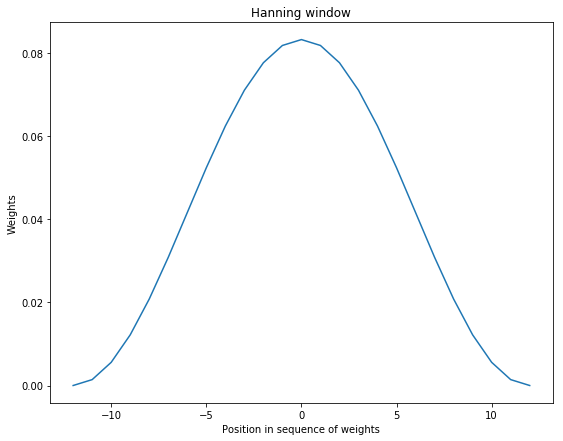

In [3]:
import numpy as np

def hanning_window(M):
    w = [0.5 - 0.5 * np.cos(2 * np.pi * n/(M-1)) for n in range(M)]
    return w

window = hanning_window(25) / np.abs(sum(hanning_window(25)))
x = np.linspace(-12, 12, 25)
plt.figure(figsize=(9, 7))
plt.plot(x, window)
plt.title("Hanning window")
plt.ylabel("Weights")
plt.xlabel("Position in sequence of weights")
plt.show()

### Estimation with Smoothing


<a id='index-9'></a>
Our next step is to provide code that will not only estimate the periodogram but also provide smoothing as required

Such functions have been written in  [estspec.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/estspec.py) and are available once you’ve installed [QuantEcon.py](http://quantecon.org/python_index.html)

The [GitHub listing](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/estspec.py) displays three functions,  `smooth()`, `periodogram()`, `ar_periodogram()`. We will discuss the first two here and the third one [below](#ar-periodograms)

The `periodogram()` function returns a periodogram, optionally smoothed via the `smooth()` function

Regarding the `smooth()` function, since smoothing adds a nontrivial amount of computation, we have applied a fairly terse array-centric method based around `np.convolve`

Readers are left either to  explore or simply to use this code according to their interests

The next three figures each show smoothed and unsmoothed periodograms, as well as the population or “true” spectral density

(The model is the same as before — see equation [(2)](#equation-esp-arma) — and there are 400 observations)

From top figure to bottom, the window length is varied from small to large


<a id='fig-window-smoothing'></a>
<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/window_smoothing.png" style="">

  
In looking at the figure, we can see that for this model and data size, the
window length chosen in the middle figure provides the best fit

Relative to this value, the first window length provides insufficient
smoothing, while the third gives too much smoothing

Of course in real estimation problems the true spectral density is not visible
and the choice of appropriate smoothing will have to be made based on
judgement/priors or some other theory


<a id='estspec-pfas'></a>

### Pre-Filtering and Smoothing


<a id='index-11'></a>
In the [code listing](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/estspec.py) we showed three functions from the file `estspec.py`

The third function in the file (`ar_periodogram()`) adds a pre-processing step to periodogram smoothing

First we describe the basic idea, and after that we give the code

The essential idea is to

1. Transform the data in order to make estimation of the spectral density more efficient  
1. Compute the periodogram associated with the transformed data  
1. Reverse the effect of the transformation on the periodogram, so that it now
  estimates the spectral density of the original process  


Step 1 is called *pre-filtering* or *pre-whitening*, while step 3 is called *recoloring*

The first step is called pre-whitening because the
transformation is usually designed to turn the data into something closer to white noise

Why would this be desirable in terms of spectral density estimation?

The reason is that we are smoothing our estimated periodogram based on
estimated values at nearby points — recall [(3)](#equation-estspec-ws)

The underlying assumption that makes this a good idea is that the true
spectral density is relatively regular — the value of $ I(\omega) $ is close
to that of $ I(\omega') $ when $ \omega $ is close to $ \omega' $

This will not be true in all cases, but it is certainly true for white noise

For white noise, $ I $ is as regular as possible — [it is a constant function](https://lectures.quantecon.org/py/arma.html#arma-wnsd)

In this case, values of $ I(\omega') $ at points $ \omega' $ near to $ \omega $
provided the maximum possible amount of information about the value $ I(\omega) $

Another way to put this is that if $ I $ is relatively constant, then we can use a large amount of smoothing without introducing too much bias


<a id='ar-periodograms'></a>

### The AR(1) Setting


<a id='index-12'></a>
Let’s examine this idea more carefully in a particular setting — where
the data are assumed to be generated by an  AR(1) process

(More general ARMA settings can be handled using similar techniques to those described below)

Suppose in particular that $ \{X_t\} $ is covariance stationary and AR(1),
with


<a id='equation-estspec-ar-dgp'></a>
$$
X_{t+1} = \mu + \phi X_t + \epsilon_{t+1} \tag{4}
$$

where $ \mu $ and $ \phi \in (-1, 1) $ are unknown parameters and $ \{ \epsilon_t \} $ is white noise

It follows that if we regress $ X_{t+1} $ on $ X_t $ and an intercept, the residuals
will approximate white noise

Let

- $ g $ be the spectral density of $ \{ \epsilon_t \} $ — a constant function, as discussed above  
- $ I_0 $ be the periodogram estimated from the residuals — an estimate of $ g $  
- $ f $ be the spectral density of $ \{ X_t \} $ — the object we are trying to estimate  


In view of [an earlier result](https://lectures.quantecon.org/py/arma.html#arma-spec-den) we obtained while discussing ARMA processes, $ f $ and $ g $ are related by


<a id='equation-ar-sdsc'></a>
$$
f(\omega) = \left| \frac{1}{1 - \phi e^{i\omega}} \right|^2 g(\omega) \tag{5}
$$

This suggests that the recoloring step, which constructs an estimate $ I $ of $ f $ from $ I_0 $, should set

$$
I(\omega) = \left| \frac{1}{1 - \hat \phi e^{i\omega}} \right|^2 I_0(\omega)
$$

where $ \hat \phi $ is the OLS estimate of $ \phi $

The code for `ar_periodogram()` — the third function in `estspec.py` — does exactly this. (See the code [here](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/estspec.py))

The next figure shows realizations of the two kinds of smoothed periodograms

1. “standard smoothed periodogram”, the ordinary smoothed periodogram, and  
1. “AR smoothed periodogram”, the pre-whitened and recolored one generated by `ar_periodogram()`  


The periodograms are calculated from time series drawn from [(4)](#equation-estspec-ar-dgp) with $ \mu = 0 $ and $ \phi = -0.9 $

Each time series is of length 150

The difference between the three subfigures is just randomness — each one uses a different draw of the time series


<a id='fig-ar-smoothed-periodogram'></a>
<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/ar_smoothed_periodogram.png" style="">

  
In all cases, periodograms are fit with the “hamming” window and window length of 65

Overall, the fit of the AR smoothed periodogram is much better, in the sense
of being closer to the true spectral density

## Exercises


<a id='estspec-ex1'></a>

### Exercise 1

Replicate [this figure](#fig-window-smoothing) (modulo randomness)

The model is as in equation [(2)](#equation-esp-arma) and there are 400 observations

For the smoothed periodogram, the window type is “hamming”


<a id='estspec-ex2'></a>

### Exercise 2

Replicate [this figure](#fig-ar-smoothed-periodogram) (modulo randomness)

The model is as in equation [(4)](#equation-estspec-ar-dgp), with $ \mu = 0 $, $ \phi = -0.9 $
and 150 observations in each time series

All periodograms are fit with the “hamming” window and window length of 65

## Solutions

In [4]:
from quantecon import ar_periodogram

### Exercise 1

/home/quantecon/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


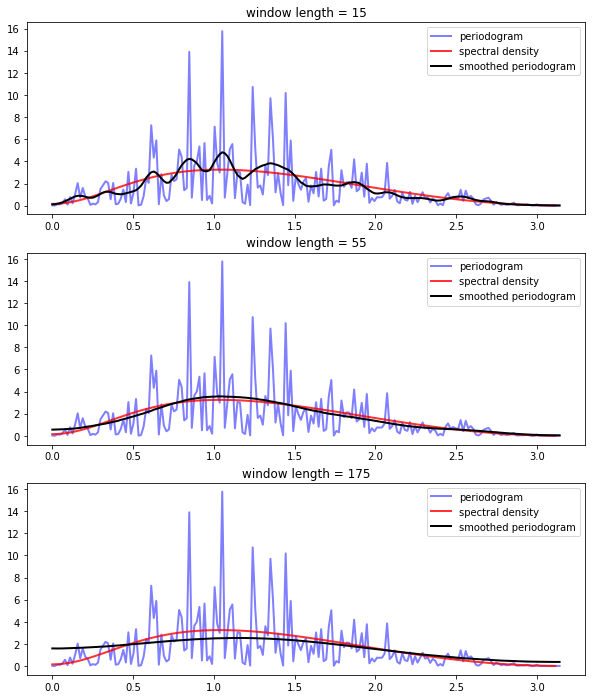

In [5]:
## Data
n = 400
ϕ = 0.5
θ = 0, -0.8
lp = ARMA(ϕ, θ)
X = lp.simulation(ts_length=n)

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

for i, wl in enumerate((15, 55, 175)):  # window lengths

    x, y = periodogram(X)
    ax[i].plot(x, y, 'b-', lw=2, alpha=0.5, label='periodogram')

    x_sd, y_sd = lp.spectral_density(two_pi=False, res=120)
    ax[i].plot(x_sd, y_sd, 'r-', lw=2, alpha=0.8, label='spectral density')

    x, y_smoothed = periodogram(X, window='hamming', window_len=wl)
    ax[i].plot(x, y_smoothed, 'k-', lw=2, label='smoothed periodogram')

    ax[i].legend()
    ax[i].set_title(f'window length = {wl}')
plt.show()

### Exercise 2

/home/quantecon/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


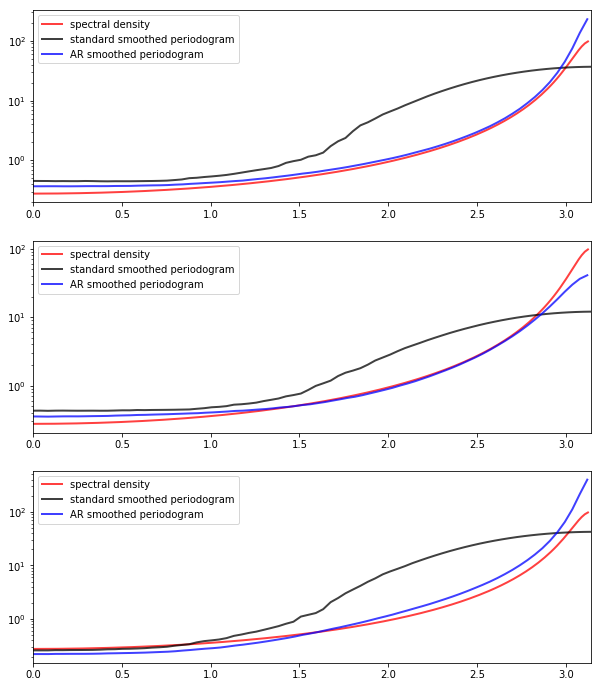

In [6]:
lp = ARMA(-0.9)
wl = 65


fig, ax = plt.subplots(3, 1, figsize=(10,12))

for i in range(3):
    X = lp.simulation(ts_length=150)
    ax[i].set_xlim(0, np.pi)

    x_sd, y_sd = lp.spectral_density(two_pi=False, res=180)
    ax[i].semilogy(x_sd, y_sd, 'r-', lw=2, alpha=0.75, label='spectral density')

    x, y_smoothed = periodogram(X, window='hamming', window_len=wl)
    ax[i].semilogy(x, y_smoothed, 'k-', lw=2, alpha=0.75, label='standard smoothed periodogram')

    x, y_ar = ar_periodogram(X, window='hamming', window_len=wl)
    ax[i].semilogy(x, y_ar, 'b-', lw=2, alpha=0.75, label='AR smoothed periodogram')

    ax[i].legend(loc='upper left')
plt.show()